By: Christian Bjerregaard (s224389) & Aske Rove (s224362)

Last edited: 04-12-2025

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
from matplotlib.lines import Line2D
import os
import glob
import torch
from torch import nn
import tqdm
import pandas as pd
from lib.utils2D import build_model_2d, build_dataloaders_2d
from lib.utils3D import build_model_3d, build_dataloaders_3d

This notebook recreates the most important results of our project.

# Model evaluation

Here we calculate the accuracy of our highest validation accuracy models on the test split of our datasets. This requires that you have `bugnist_064`, `bugnist_128` and `bugnist_256_screenshots` in the root directory (alongside lib, models and so on from the repo).

In [ ]:
models_path = "./models/"

# Find models
model_paths = glob.glob(os.path.join(models_path, "*.pt"))
print(f"Found {len(model_paths)} models.")

models_2d = [model for model in model_paths if "bugnist_256" in model]
models_3d = [model for model in model_paths if ("bugnist_064" in model or "bugnist_128" in model)]
models_2d.sort()
models_3d.sort()

models_paths = models_2d + models_3d

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

# List to collect results
results = []

# Test each model
for i, path in enumerate(models_paths):
    # Get run information from filename
    run_name = os.path.basename(path)

    # 2d models
    if i < 4:
        model_name = run_name.split("_")[0]
        dropout_prob = float(run_name.split("_")[2].replace("dp", ""))
        views = int(run_name.split("_")[-1].replace(".pt", "").replace("views", ""))
        dataset = "bugnist_256_screenshots"

        # 6 views - build dataloader
        if views == 6:
            batch_size = 5
            _, _, test_loader = build_dataloaders_2d(f"./{dataset}/", batch_size, views=6)
            model = build_model_2d(model_name, num_classes=12, dropout_prob=dropout_prob, views=6)
        # 2 views - build dataloader
        else:
            batch_size = 15
            _, _, test_loader = build_dataloaders_2d(f"./{dataset}/", batch_size, views=2)
            model = build_model_2d(model_name, num_classes=12, dropout_prob=dropout_prob, views=2)
        
        # Build model
        model.load_state_dict(torch.load(path, map_location=device))
        model.eval()
        model.to(device)

    # 3d models
    else:
        model_name = run_name.split("_")[0]
        dropout_prob = float(run_name.split("_")[2].replace("dp", ""))
        dataset = run_name.split("_")[3] + "_" + run_name.split("_")[4].replace(".pt", "")

        # Set batch size based on dataset
        if dataset == "bugnist_064":
            batch_size = 32
        elif dataset == "bugnist_128":
            batch_size = 4
        else:
            raise ValueError(f"Unknown dataset: {dataset}")
        # Build dataset and dataloader
        _, _, test_loader = build_dataloaders_3d(f"./{dataset}/", batch_size)
        # Build model
        model = build_model_3d(model_name, num_classes=12, dropout_prob=dropout_prob)
        model.load_state_dict(torch.load(path, map_location=device))
        model.eval()
        model.to(device)

    print(f"Evaluating model: {model_name}, Dropout: {dropout_prob}, Dataset: {dataset}")

    # Evaluate model on test set
    test_loss_sum = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for xb, yb in tqdm.tqdm(test_loader):
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)

            test_loss_sum += loss.item() * xb.size(0)

            pred_labels = preds.argmax(dim=1)
            test_correct += (pred_labels == yb).sum().item()
            test_total += yb.size(0)

    avg_test_loss = test_loss_sum / test_total
    test_acc = test_correct / test_total

    print(
        f"Test Loss: {avg_test_loss:.4f}, "
        f"Test Accuracy: {test_acc:.4f}"
    )

    # Save results for this model
    results.append(
        {
            "run_name": run_name,
            "model_name": model_name,
            "dropout_prob": dropout_prob,
            "dataset": dataset,
            "batch_size": batch_size,
            "test_loss": avg_test_loss,
            "test_accuracy": test_acc,
        }
    )

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Show and/or save
print("\nEvaluation summary:")
df_results

Found 8 models.
Run name: conv2d_lr0.0005_dp0.0_pretrained=False_BugNIST_256_screenshots_views6.pt
BugNIST_256_screenshots
Evaluating model: conv2d, Dropout: 0.0, Dataset: BugNIST_256_screenshots


100%|██████████| 274/274 [00:22<00:00, 12.35it/s]


Test Loss: 0.1375, Test Accuracy (best-val model): 0.9562
Run name: densenet_lr0.0005_dp0.0_pretrained=True_BugNIST_256_screenshots_views6.pt
BugNIST_256_screenshots
Evaluating model: densenet, Dropout: 0.0, Dataset: BugNIST_256_screenshots


100%|██████████| 274/274 [00:20<00:00, 13.06it/s]


Test Loss: 0.4892, Test Accuracy (best-val model): 0.9474
Run name: resnet_lr0.0005_dp0.0_pretrained=True_BugNIST_256_screenshots_views6.pt
BugNIST_256_screenshots
Evaluating model: resnet, Dropout: 0.0, Dataset: BugNIST_256_screenshots


100%|██████████| 274/274 [00:20<00:00, 13.64it/s]


Test Loss: 0.3073, Test Accuracy (best-val model): 0.9365
Run name: unet_lr0.0005_dp0.0_pretrained=False_BugNIST_256_screenshots_views2.pt
BugNIST_256_screenshots
Evaluating model: unet, Dropout: 0.0, Dataset: BugNIST_256_screenshots


100%|██████████| 91/91 [00:17<00:00,  5.22it/s]


Test Loss: 0.2180, Test Accuracy (best-val model): 0.9458
Run name: conv3d_lr0.0005_dp0.2_bugnist_128.pt
bugnist_128
Evaluating model: conv3d, Dropout: 0.2, Dataset: bugnist_128


100%|██████████| 344/344 [00:51<00:00,  6.74it/s]


Test Loss: 0.1766, Test Accuracy (best-val model): 0.9578
Run name: densenet_lr0.0005_dp0.2_bugnist_128.pt
bugnist_128
Evaluating model: densenet, Dropout: 0.2, Dataset: bugnist_128


100%|██████████| 344/344 [00:28<00:00, 12.25it/s]


Test Loss: 0.1497, Test Accuracy (best-val model): 0.9541
Run name: resnet_lr0.0005_dp0.0_bugnist_128.pt
bugnist_128
Evaluating model: resnet, Dropout: 0.0, Dataset: bugnist_128


100%|██████████| 344/344 [00:38<00:00,  9.02it/s]


Test Loss: 0.2401, Test Accuracy (best-val model): 0.9425
Run name: unet_lr0.0005_dp0.2_bugnist_128.pt
bugnist_128
Evaluating model: unet, Dropout: 0.2, Dataset: bugnist_128


100%|██████████| 344/344 [00:16<00:00, 21.01it/s]

Test Loss: 0.2326, Test Accuracy (best-val model): 0.9272

Evaluation summary:
                                            run_name model_name  dropout_prob  \
0  conv2d_lr0.0005_dp0.0_pretrained=False_BugNIST...     conv2d           0.0   
1  densenet_lr0.0005_dp0.0_pretrained=True_BugNIS...   densenet           0.0   
2  resnet_lr0.0005_dp0.0_pretrained=True_BugNIST_...     resnet           0.0   
3  unet_lr0.0005_dp0.0_pretrained=False_BugNIST_2...       unet           0.0   
4               conv3d_lr0.0005_dp0.2_bugnist_128.pt     conv3d           0.2   
5             densenet_lr0.0005_dp0.2_bugnist_128.pt   densenet           0.2   
6               resnet_lr0.0005_dp0.0_bugnist_128.pt     resnet           0.0   
7                 unet_lr0.0005_dp0.2_bugnist_128.pt       unet           0.2   

                   dataset  batch_size  test_loss  test_accuracy  
0  BugNIST_256_screenshots           5   0.137537       0.956204  
1  BugNIST_256_screenshots           5   0.489156       0

# Report illustrations

This section recreates the most important figures and illustrations from our project report.

In [ ]:
# Read in csv data
df3 = pd.read_csv("result_data/3D_results.csv")
df2 = pd.read_csv("result_data/2D_results.csv")
df2_ablation = pd.read_csv("result_data/2D_results_ablation.csv") # Index from Aske
df3_train_accs = pd.read_csv("result_data/BugNIST3d_train_accuracy.csv")
df3_train_accs_others = pd.read_csv("result_data/BugNIST3d_train_accuracy_others.csv")
df3_val_accs = pd.read_csv("result_data/BugNIST3d_val_accuracy.csv")
df3_val_accs_others = pd.read_csv("result_data/BugNIST3d_val_accuracy_others.csv")
df3_final_train_accs = pd.read_csv("result_data/BugNIST3d_final_train_accuracy.csv")
df3_final_val_accs = pd.read_csv("result_data/BugNIST3d_final_val_accuracy.csv")
df_LR_train = pd.read_csv("result_data/LR_train_acc.csv")
df_LR_val = pd.read_csv("result_data/LR_val_acc.csv")

## Learning rate study

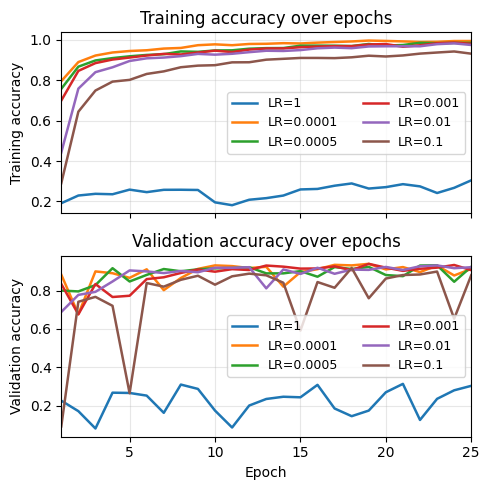

In [ ]:
def get_acc_cols_train(df):
    return [c for c in df.columns 
            if c.endswith(" - train_accuracy") and "__" not in c]

def get_acc_cols_val(df):
    return [c for c in df.columns 
            if c.endswith(" - val_accuracy") and "__" not in c]

fig, axes = plt.subplots(2, 1, figsize=(5, 5), sharex=True)

# Plot 1 - df_LR_train
df_main = df_LR_train
main_cols = get_acc_cols_train(df_main)

ax = axes[0]
for col in main_cols:
    ax.plot(
        df_main["Step"] + 1,
        df_main[col],
        label=col.split(" - ")[0]
                .replace("_dp0.0_bugnist_064", "")
                .replace("resnet_lr", "LR=")
                .replace("1.01", "1"),
        linewidth=1.8
    )

ax.set_ylabel("Training accuracy")
ax.set_title("Training accuracy over epochs")
ax.legend(fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)
ax.margins(x=0)
ax.set_xlim(1, 25)

# Plot 2 - df_LR_val
df_main = df_LR_val
main_cols = get_acc_cols_val(df_main)

ax = axes[1]
for col in main_cols:
    ax.plot(
        df_main["Step"] + 1,
        df_main[col],
        label=col.split(" - ")[0]
                .replace("_dp0.0_bugnist_064", "")
                .replace("resnet_lr", "LR=")
                .replace("1.01", "1"),
        linewidth=1.8
    )

ax.set_xlabel("Epoch")
ax.set_ylabel("Validation accuracy")
ax.set_title("Validation accuracy over epochs")
ax.legend(fontsize=9, ncol=2, loc='right')
ax.grid(True, alpha=0.3)
ax.margins(x=0)
ax.set_xlim(1, 25)

plt.tight_layout()
plt.show()

## 3D ablation study

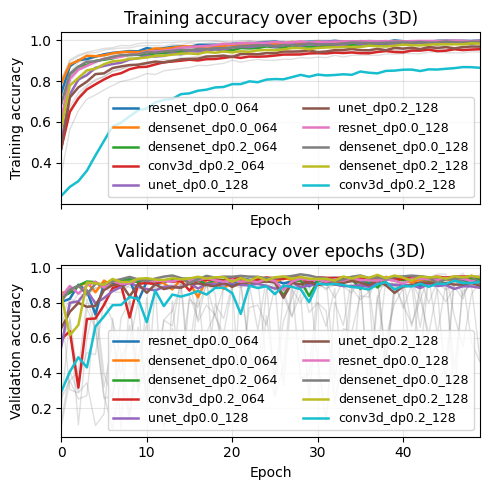

In [68]:
def get_acc_cols_train(df):
    return [c for c in df.columns 
            if c.endswith(" - train_accuracy") and "__" not in c]

def get_acc_cols_val(df):
    return [c for c in df.columns 
            if c.endswith(" - val_accuracy") and "__" not in c]

fig, axes = plt.subplots(2, 1, figsize=(5, 5), sharex=True)


# Plot 1 - df3_train_accs
df_main = df3_train_accs
df_other = df3_train_accs_others

main_cols = get_acc_cols_train(df_main)
other_cols = get_acc_cols_train(df_other)

ax = axes[0]
# --- Background curves (OTHER MODELS) ---
for col in other_cols:
    ax.plot(
        df_other["Step"],
        df_other[col],
        color="grey",
        alpha=0.25,      # semi-transparent
        linewidth=1
    )

# --- Foreground curves (MAIN MODELS) ---
for col in main_cols:
    ax.plot(
        df_main["Step"],
        df_main[col],
        label=col.split(" - ")[0].replace("_lr0.0005", "").replace("bugnist_", ""),  # shorter names
        linewidth=1.8
    )

ax.set_xlabel("Epoch")
ax.set_ylabel("Training accuracy")
ax.set_title("Training accuracy over epochs (3D)")
ax.legend(fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)
ax.margins(x=0)


# Plot 2 - df3_val_accs
df_main = df3_val_accs
df_other = df3_val_accs_others

main_cols = get_acc_cols_val(df_main)
other_cols = get_acc_cols_val(df_other)

ax = axes[1]
# --- Background curves (OTHER MODELS) ---
for col in other_cols:
    ax.plot(
        df_other["Step"],
        df_other[col],
        color="grey",
        alpha=0.25,      # semi-transparent
        linewidth=1
    )

# --- Foreground curves (MAIN MODELS) ---
for col in main_cols:
    ax.plot(
        df_main["Step"],
        df_main[col],
        label=col.split(" - ")[0].replace("_lr0.0005", "").replace("bugnist_", ""),  # shorter names
        linewidth=1.8
    )

ax.set_xlabel("Epoch")
ax.set_ylabel("Validation accuracy")
ax.set_title("Validation accuracy over epochs (3D)")
ax.legend(fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)
ax.margins(x=0)

plt.tight_layout()
plt.show()

## 3D ablation study selected models continued

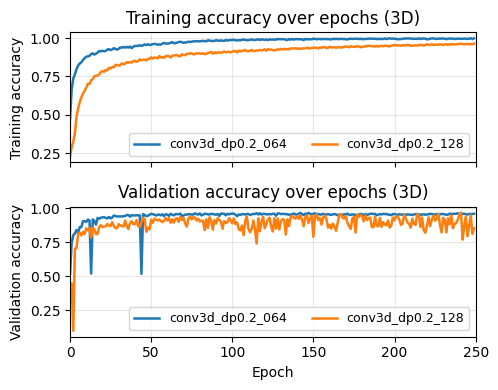

In [101]:
def get_acc_cols_train(df):
    return [c for c in df.columns 
            if c.endswith(" - train_accuracy") and "__" not in c]

def get_acc_cols_val(df):
    return [c for c in df.columns 
            if c.endswith(" - val_accuracy") and "__" not in c]

fig, axes = plt.subplots(2, 1, figsize=(5, 4), sharex=True)

# ---------------- TRAIN ----------------
df_train = df3_final_train_accs
train_cols = get_acc_cols_train(df_train)

ax = axes[0]
for col in train_cols:
    ax.plot(
        df_train["Step"],
        df_train[col],
        label=col.split(" - ")[0]
                .replace("_lr0.0005", "")
                .replace("bugnist_", ""),
        linewidth=1.8
    )

ax.set_ylabel("Training accuracy")
ax.set_title("Training accuracy over epochs (3D)")
ax.legend(fontsize=9, ncol=2, loc="lower right")
ax.grid(True, alpha=0.3)
ax.margins(x=0)
ax.set_xlim(0, 250)

# ---------------- VALIDATION ----------------
df_val = df3_final_val_accs
val_cols = get_acc_cols_val(df_val)

ax = axes[1]
for col in val_cols:
    ax.plot(
        df_val["Step"],
        df_val[col],
        label=col.split(" - ")[0]
                .replace("_lr0.0005", "")
                .replace("bugnist_", ""),
        linewidth=1.8
    )

ax.set_xlabel("Epoch")
ax.set_ylabel("Validation accuracy")
ax.set_title("Validation accuracy over epochs (3D)")
ax.legend(fontsize=9, ncol=2, loc="lower right")
ax.grid(True, alpha=0.3)
ax.margins(x=0)
ax.set_xlim(0, 250)

plt.tight_layout()
plt.show()


## 2D ablation study

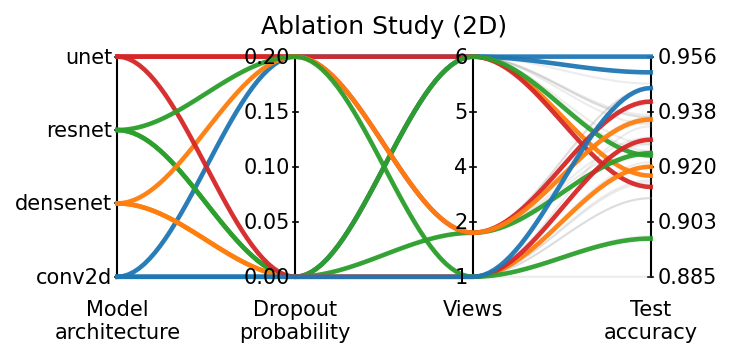

In [ ]:
# ---------- helpers ----------
def bezier_curve(P0, P1, P2, P3, n=40):
    """Cubic Bezier from P0 to P3 with control points P1,P2. Returns (x,y) arrays."""
    t = np.linspace(0, 1, n)
    B = ((1-t)**3)[:, None] * P0 + (3*(1-t)**2*t)[:, None] * P1 + (3*(1-t)*t**2)[:, None] * P2 + (t**3)[:, None] * P3
    return B[:, 0], B[:, 1]

def norm01(x, vmin, vmax):
    if vmax == vmin:
        return np.zeros_like(x, dtype=float)
    return (x - vmin) / (vmax - vmin)

def nice_ticks(vmin, vmax, n=5):
    # simple: n ticks linearly spaced (good enough for these hyperparams)
    if vmax == vmin:
        return [vmin]
    return np.linspace(vmin, vmax, n)


axis_labels = {
    "model_type": "Model\narchitecture",
    "dropout_prob": "Dropout\nprobability",
    "views": "Views",
    "test_accuracy": "Test\naccuracy",
}

# ---------- your data ----------
df = df2_ablation

index_to_highlight = [1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1]
mask = np.array(index_to_highlight, dtype=bool)
assert len(mask) == len(df), f"Mismatch: list has {len(mask)} but df has {len(df)} rows"

# Choose axis order (include model_type if you want it as an axis)
axes = ["model_type", "dropout_prob", "views", "test_accuracy"]

# Categorical mapping for model_type axis
model_order = ["conv2d", "densenet", "resnet", "unet"]
present = [m for m in model_order if m in set(df["model_type"])]
# add any extra unseen types at the end
present += [m for m in sorted(set(df["model_type"]) - set(present))]

cat_to_code = {m: i for i, m in enumerate(present)}
k = len(present)
df["_model_code"] = df["model_type"].map(cat_to_code)

# Prepare per-axis ranges (in original units)
ranges = {}
ranges["model_type"] = (0, max(1, k - 1))
for col in ["dropout_prob", "views", "test_accuracy"]:
    ranges[col] = (df[col].min(), df[col].max())

# Convert each row into normalized y-values per axis
Y = np.zeros((len(df), len(axes)), dtype=float)
for j, col in enumerate(axes):
    vmin, vmax = ranges[col]
    if col == "model_type":
        Y[:, j] = norm01(df["_model_code"].to_numpy(dtype=float), vmin, vmax)
    else:
        Y[:, j] = norm01(df[col].to_numpy(dtype=float), vmin, vmax)

# Positions of the vertical axes
xpos = np.arange(len(axes), dtype=float)

# Distinct colors by model_type (only for highlighted lines)
cmap = plt.get_cmap("tab10")
model_colors = {m: cmap(i % 10) for i, m in enumerate(present)}

# ---------- plot ----------
fig, ax = plt.subplots(figsize=(5, 2.5), dpi=150)
ax.set_xlim(xpos[0] - 0.2, xpos[-1] + 0.2)
ax.set_ylim(-0.05, 1.05)
ax.axis("off")

# Draw vertical axes + ticks/labels in original units
for j, col in enumerate(axes):
    x = xpos[j]
    ax.plot([x, x], [0, 1], color="black", lw=1)

    # Axis label under each vertical axis
    ax.text(
        x, -0.10,
        axis_labels.get(col, col),
        ha="center", va="top", fontsize=10
    )

    if col == "model_type":
        # categorical ticks
        for m, code in cat_to_code.items():
            y = norm01(float(code), *ranges["model_type"])
            ax.plot([x - 0.015, x + 0.015], [y, y], color="black", lw=0.8)
            ax.text(x - 0.03, y, m, ha="right", va="center", fontsize=10)
    else:
        vmin, vmax = ranges[col]
        for tv in nice_ticks(vmin, vmax, n=5):
            y = norm01(tv, vmin, vmax)
            ax.plot([x - 0.015, x + 0.015], [y, y], color="black", lw=0.8)
            # format: fewer decimals for views, more for dropout/accuracy
            if col == "views":
                lab = f"{tv:.0f}"
            elif col == "dropout_prob":
                lab = f"{tv:.2f}"
            else:
                lab = f"{tv:.3f}"

            # >>> MOVE test_accuracy tick labels <<<
            if col == "test_accuracy":
                ax.text(
                    x + 0.04, y, lab,
                    ha="left", va="center", fontsize=10,
                    bbox=dict(facecolor="white", edgecolor="none", alpha=0.8, pad=0.3)
                )
            else:
                ax.text(x - 0.03, y, lab, ha="right", va="center", fontsize=10)

# Draw curved lines (grey background first, then highlighted)
curv = 0.35 # 0..0.5ish; higher = “curvier”

def draw_row(i, alpha, lw, color):
    ys = Y[i]
    # piecewise Bezier between consecutive axes
    X_all, Y_all = [], []
    for j in range(len(axes) - 1):
        x0, y0 = xpos[j], ys[j]
        x1, y1 = xpos[j + 1], ys[j + 1]
        dx = x1 - x0

        P0 = np.array([x0, y0])
        P3 = np.array([x1, y1])
        P1 = np.array([x0 + curv * dx, y0])
        P2 = np.array([x1 - curv * dx, y1])

        xx, yy = bezier_curve(P0, P1, P2, P3, n=35)
        if j > 0:
            xx, yy = xx[1:], yy[1:]  # avoid duplicate points at joints
        X_all.append(xx)
        Y_all.append(yy)

    ax.plot(np.concatenate(X_all), np.concatenate(Y_all), color=color, alpha=alpha, lw=lw)

# greyed out
for i in np.where(~mask)[0]:
    draw_row(i, alpha=0.18, lw=1.0, color=(0.6, 0.6, 0.6))

# highlighted
for i in np.where(mask)[0]:
    m = df.loc[i, "model_type"]
    draw_row(i, alpha=0.95, lw=2.2, color=model_colors.get(m, "C0"))

plt.title("Ablation Study (2D)", fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig("parallel_curved.png", bbox_inches="tight", dpi=300)

## 3D and 2D boxplots

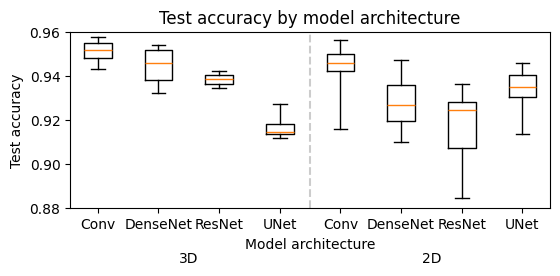

In [64]:
df_3d = df3.drop(index=[1, 4])
df_2d = df2

rename_3d = {"conv3d": "Conv", "densenet": "DenseNet", "resnet": "ResNet", "unet": "UNet"}
rename_2d = {"conv2d": "Conv", "densenet": "DenseNet", "resnet": "ResNet", "unet": "UNet"}

def pretty_name(mt, mapping):
    for key in mapping:
        if mt.startswith(key):
            return mapping[key]
    return mt

labels_3d = []
data_3d = []
for mt in sorted(df_3d["model_type"].unique()):
    label = pretty_name(mt, rename_3d)
    labels_3d.append(label)
    data_3d.append(df_3d.loc[df_3d["model_type"] == mt, "test_accuracy"].values)

labels_2d = []
data_2d = []
for mt in sorted(df_2d["model_type"].unique()):
    label = pretty_name(mt, rename_2d)
    labels_2d.append(label)
    data_2d.append(df_2d.loc[df_2d["model_type"] == mt, "test_accuracy"].values)

spacing = 1.1
gap = 0.0

n3 = len(labels_3d)
n2 = len(labels_2d)

pos_3d = np.arange(1, n3 + 1) * spacing
pos_2d = pos_3d[-1] + gap + np.arange(1, n2 + 1) * spacing

data = data_3d + data_2d
positions = np.concatenate([pos_3d, pos_2d])
labels = labels_3d + labels_2d

plt.figure(figsize=(5.7, 3))
plt.boxplot(
    data,
    positions=positions,
    tick_labels=labels,
    showfliers=False,
    whis=[0, 100]
)

plt.xlabel("Model architecture")
plt.ylabel("Test accuracy")
plt.title("Test accuracy by model architecture")

ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(0.02))
ax.set_ylim(0.88, 0.96)

ax.set_xticks(positions)
ax.set_xticklabels(labels)

mid = (pos_3d[-1] + pos_2d[0]) / 2
ax.axvline(mid, color="grey", linestyle="--", alpha=0.4)

ax.text((pos_3d[0] + pos_3d[-1]) / 2, -0.25, "3D",
        transform=ax.get_xaxis_transform(), ha="center", va="top")
ax.text((pos_2d[0] + pos_2d[-1]) / 2, -0.25, "2D",
        transform=ax.get_xaxis_transform(), ha="center", va="top")

plt.tight_layout()
plt.show()


## 2D views boxplot

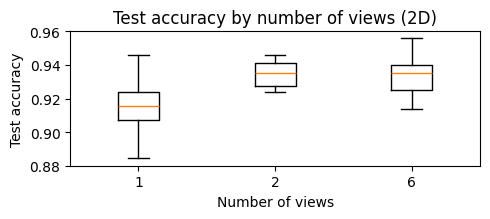

In [66]:
groups = df2.groupby("views")["test_accuracy"]

data = [groups.get_group(mt).values for mt in groups.groups]
labels = list(groups.groups.keys())

plt.figure(figsize=(5, 2.3))
plt.boxplot(
    data,
    tick_labels=labels,
    showfliers=False,    # don't mark outliers
    whis=[0, 100]
    )
plt.xlabel("Number of views")
plt.ylabel("Test accuracy")
plt.title("Test accuracy by number of views (2D)")
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(0.02))
ax.set_ylim(0.88, 0.96)
plt.tight_layout()
plt.show()
